# Long Short Term Memory (LSTM) Neural Networks

In [1]:
from keras import layers

In [2]:
layers

<module 'keras.layers' from '/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/keras/layers/__init__.py'>

<img width="500" src="https://www.tensorflow.org/static/tutorials/structured_data/time_series_files/output_JjEkt488hi8I_0.png"/>

Source: https://www.tensorflow.org/tutorials/structured_data/time_series#performance

## Load Dataset

In [3]:
import pandas as pd

df = pd.read_csv('../data/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
...,...
2023-08-04 20:00:00+00:00,94.00
2023-08-04 21:00:00+00:00,91.70


## Data Preprocessing

In [4]:
## Data Preprocessing

### Scale Data

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(df)

df_norm = pd.DataFrame(data_norm, index=df.index, columns=df.columns)
df_norm

### Train Test Split

from sklearn.model_selection import train_test_split

# Split into training and testing sets (e.g., 80/20 split)
train, test = train_test_split(df_norm, test_size=0.2, shuffle=False)
df_norm

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,0.055143
2020-01-01 01:00:00+00:00,0.052214
...,...
2023-08-04 20:00:00+00:00,0.134286
2023-08-04 21:00:00+00:00,0.131000


### Create Sequences. Why?

#### Feature Selection (X,y) in Conventional Machine Learning

In [5]:
import seaborn as sns

df_cars = (sns
 .load_dataset(name='car_crashes', index_col='abbrev')
 .rename({'total': 'accidents'}, axis=1))

X = df_cars.drop(columns='accidents')
X

,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,
AL,7.332,5.640,18.048,15.040,784.55,145.08
AK,7.421,4.525,16.290,17.014,1053.48,133.93
...,...,...,...,...,...,...
WI,4.968,4.554,5.382,11.592,670.31,106.62
WY,7.308,5.568,14.094,15.660,791.14,122.04


In [6]:
y = df_cars[['accidents']]
y

,accidents
abbrev,
AL,18.8
AK,18.1
...,...
WI,13.8
WY,17.4


#### Feature Selection (X,y) in Neural Networks

In [7]:
df_norm

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,0.055143
2020-01-01 01:00:00+00:00,0.052214
...,...
2023-08-04 20:00:00+00:00,0.134286
2023-08-04 21:00:00+00:00,0.131000


<center>
    
[10, 20, 30, 40, 50, 60, 70, ...]

</center>

---

Hour | X | y 
-|-|-
4 | [10, 20, 30] | [40]
5 | [20, 30, 40] | [50]
6 | [30, 40, 50] | [60]
... | ... | ...

#### Timestamp 1

In [8]:
import numpy as np

def create_sequences(df, sequence_length):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length])
        y.append(df.iloc[i+sequence_length])
    return X, y

sequence_length = 3
df_X, df_y = create_sequences(df_norm, sequence_length)

def create_sequences(df, sequence_length):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length])
        y.append(df.iloc[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

df_X[0]

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,0.055143
2020-01-01 01:00:00+00:00,0.052214
2020-01-01 02:00:00+00:00,0.046171


In [9]:
df_y[0]

Mercado SPOT    0.044071
Name: 2020-01-01 03:00:00+00:00, dtype: float64

#### Timestamp 2

In [10]:
df_X[1]

,Mercado SPOT
datetime_utc,
2020-01-01 01:00:00+00:00,0.052214
2020-01-01 02:00:00+00:00,0.046171
2020-01-01 03:00:00+00:00,0.044071


In [11]:
df_y[1]

Mercado SPOT    0.043057
Name: 2020-01-01 04:00:00+00:00, dtype: float64

## Modelling

### Design NN Architecture

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential(layers=[
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/keras/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train Model

In [13]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, verbose=1,
    validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3:06 474ms/step - loss: 0.0341


 53/395 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 0.0165  


117/395 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0114


193/395 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0085


268/395 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.0070


339/395 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0061


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0055 - val_loss: 0.0010


Epoch 2/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0012


 74/395 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 7.8218e-04


149/395 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 7.7306e-04


222/395 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 7.6302e-04


291/395 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 7.5352e-04


365/395 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 7.4579e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 7.4277e-04 - val_loss: 9.4580e-04


Epoch 3/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.9377e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 6.8557e-04


153/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 6.7045e-04


230/395 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 6.5770e-04


306/395 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 6.4371e-04


382/395 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 6.3516e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 6.3390e-04 - val_loss: 7.7811e-04


Epoch 4/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.3064e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 4.8284e-04


151/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 4.8705e-04


228/395 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 4.8473e-04


305/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 4.8006e-04


382/395 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 4.7679e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 4.7611e-04 - val_loss: 5.7936e-04


Epoch 5/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.0210e-04


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 3.4539e-04


155/395 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 3.4822e-04


234/395 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 3.4980e-04


311/395 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 3.4796e-04


387/395 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 3.4482e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 3.4443e-04 - val_loss: 4.3058e-04


Epoch 6/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.4133e-04


 78/395 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 3.0808e-04


153/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 3.1430e-04


229/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 3.0893e-04


304/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 3.0414e-04


381/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 3.0038e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 2.9969e-04 - val_loss: 4.1072e-04


Epoch 7/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.3982e-04


 75/395 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 2.7917e-04


152/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.6893e-04


228/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 2.6690e-04


304/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 2.6678e-04


381/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 2.6671e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 2.6665e-04 - val_loss: 3.5894e-04


Epoch 8/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.3601e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 2.4618e-04


151/395 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 2.5282e-04


227/395 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 2.5408e-04


302/395 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 2.5514e-04


378/395 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 2.5494e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 2.5485e-04 - val_loss: 3.7035e-04


Epoch 9/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.4707e-04


 78/395 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 2.5515e-04


153/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.5116e-04


229/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.4781e-04


305/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.4668e-04


383/395 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 2.4563e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 2.4548e-04 - val_loss: 3.3999e-04


Epoch 10/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.8350e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 2.3476e-04


151/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2.3087e-04


229/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 2.2879e-04


306/395 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 2.2820e-04


384/395 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 2.2898e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 2.2920e-04 - val_loss: 3.2644e-04


Epoch 11/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1994e-04


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 2.2539e-04


153/395 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 2.2351e-04


229/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.2433e-04


305/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.2587e-04


380/395 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 2.2721e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 2.2760e-04 - val_loss: 3.2928e-04


Epoch 12/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1508e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2.5112e-04


150/395 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 2.4746e-04


226/395 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 2.4267e-04


301/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2.4065e-04


377/395 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 2.3936e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 2.3912e-04 - val_loss: 3.4115e-04


Epoch 13/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.4436e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 2.0260e-04


152/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.1097e-04


228/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 2.1746e-04


297/395 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 2.2224e-04


372/395 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 2.2518e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.2590e-04 - val_loss: 3.2312e-04


Epoch 14/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.4022e-04


 75/395 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 2.1147e-04


152/395 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 2.2122e-04


227/395 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 2.2528e-04


304/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 2.2694e-04


381/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 2.2773e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 2.2790e-04 - val_loss: 3.3733e-04


Epoch 15/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6190e-04


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 2.2128e-04


155/395 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 2.2287e-04


230/395 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 2.2379e-04


303/395 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 2.2507e-04


380/395 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 2.2736e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 2.2764e-04 - val_loss: 3.2439e-04


Epoch 16/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.6730e-04


 75/395 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 2.3693e-04


152/395 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 2.3178e-04


228/395 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 2.2957e-04


304/395 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 2.2908e-04


378/395 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 2.2939e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.2949e-04 - val_loss: 3.1982e-04


Epoch 17/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.4458e-05


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 2.1291e-04


154/395 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 2.2074e-04


231/395 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 2.2445e-04


308/395 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 2.2653e-04


384/395 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 2.2748e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 2.2759e-04 - val_loss: 3.1882e-04


Epoch 18/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5486e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 2.2446e-04


152/395 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 2.3430e-04


230/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 2.3455e-04


307/395 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 2.3404e-04


381/395 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.3331e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 2.3324e-04 - val_loss: 3.2892e-04


Epoch 19/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.9242e-04


 75/395 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 2.2619e-04


152/395 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 2.3119e-04


227/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2.2831e-04


303/395 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 2.2764e-04


378/395 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 2.2854e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.2879e-04 - val_loss: 3.1903e-04


Epoch 20/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.4040e-04


 73/395 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 2.2093e-04


148/395 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 2.3136e-04


222/395 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 2.3200e-04


297/395 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 2.3178e-04


372/395 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 2.3127e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 2.3120e-04 - val_loss: 3.1677e-04


Epoch 21/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4632e-04


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 2.1689e-04


154/395 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 2.2063e-04


232/395 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 2.2368e-04


308/395 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 2.2625e-04


384/395 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 2.2833e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 2.2849e-04 - val_loss: 3.1307e-04


Epoch 22/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.5501e-05


 72/395 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 2.5608e-04


148/395 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 2.4466e-04


224/395 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 2.4070e-04


301/395 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 2.3865e-04


376/395 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 2.3723e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 2.3693e-04 - val_loss: 3.1474e-04


Epoch 23/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.3519e-04


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 2.1640e-04


155/395 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 2.1691e-04


232/395 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 2.2000e-04


309/395 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 2.2317e-04


376/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2.2479e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 2.2504e-04 - val_loss: 3.1170e-04


Epoch 24/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.6441e-04


 74/395 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 2.2937e-04


149/395 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 2.3387e-04


225/395 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 2.3229e-04


300/395 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 2.3106e-04


376/395 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2.3052e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.3046e-04 - val_loss: 3.2095e-04


Epoch 25/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.4768e-04


 77/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 2.3557e-04


153/395 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 2.3915e-04


228/395 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 2.3742e-04


304/395 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 2.3584e-04


376/395 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 2.3482e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.3458e-04 - val_loss: 3.2145e-04


Epoch 26/50



  1/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.0400e-04


 76/395 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 2.4968e-04


150/395 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 2.4182e-04


226/395 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 2.3920e-04


299/395 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 2.3788e-04


369/395 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 2.3666e-04


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 2.3623e-04 - val_loss: 3.1499e-04


### Calculate Predictions

In [14]:
y_pred = model.predict(X_test)
y_pred

### Comparison: Real Data & Prediction

#### Descale Data

y_pred_scaled_inverse = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_test)

#### Create DataFrame
import sys
sys.path.append('../')

import utils

dic_pred = {
    'y_pred': y_pred,
    'y_pred_scaled_inverse': y_pred_scaled_inverse,
}

df_pred = utils.process_df_pred(df_norm, y_test, dic_pred)
df_pred = df_pred.merge(df, left_index=True, right_index=True)
df_pred


  1/198 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step


151/198 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


/Users/sota/Library/CloudStorage/Dropbox/2 Business/1 Datons/2 Areas/Courses/22 TS/solutions-new/notebooks/60_Forecasting II Deep Learning/0_Overview/../utils.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=date_start, end=date_end, freq='H')


,y_true,y_pred,y_pred_scaled_inverse,Mercado SPOT
2022-11-15 01:00:00+00:00,0.129086,0.125618,87.932899,90.36
2022-11-15 02:00:00+00:00,0.128500,0.129593,90.714798,89.95
...,...,...,...,...
2023-08-04 20:00:00+00:00,0.134286,0.139155,97.408806,94.00
2023-08-04 21:00:00+00:00,0.131000,0.135120,94.584251,91.70


### Evaluate Model

In [15]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(df_pred['Mercado SPOT'], df_pred.y_pred_scaled_inverse)

12.370280717726288

### Visualize Model Predictions

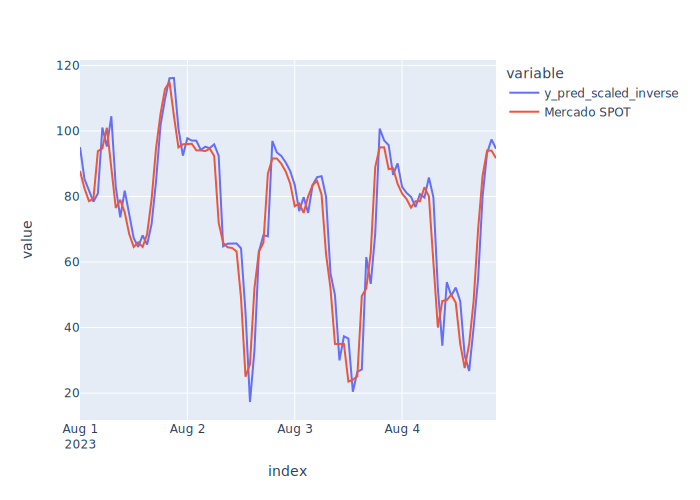

In [16]:
dff = df_pred.loc['2023-08-01':].copy()
utils.plot_df(dff[['y_pred_scaled_inverse', 'Mercado SPOT']])